In [1]:
from bs4 import BeautifulSoup
import requests
import re
import string
from tqdm.notebook import tqdm

In [2]:
import zipfile
import os
import pickle
import Levenshtein

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [9]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB

In [10]:
from xgboost import XGBRFClassifier

In [11]:
#!kaggle competitions download -c spaceship-titanic

In [12]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

target = "Transported"

test[target] = -1

In [13]:
all_data = train.append(test)
all_data.reset_index(inplace=True, drop=True)

all_data.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [21]:
data = all_data.copy()

data["Id"] = data["PassengerId"].apply(lambda x: int(str(x)[-2:]))
data["_Cabin"] = data["Cabin"].apply(lambda x: str(x)[: 1] if isinstance(x, str) else x)

data["Cabin_"] = data["Cabin"].apply(lambda x: str(x)[-1:] if isinstance(x, str) else x)
data["_Cabin_"] = data["Cabin"].apply(lambda x: int(str(x)[2: -2]) if isinstance(x, str) else x)

In [22]:
del data["PassengerId"]
del data["Cabin"]

In [23]:
data["CryoSleep"] = data["CryoSleep"].astype(float)
data["VIP"] = data["VIP"].astype(float)

In [24]:
data.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Id,_Cabin,Cabin_,_Cabin_
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,B,P,0.0
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,F,S,0.0
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,A,S,0.0
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,2,A,S,0.0
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,F,S,1.0


In [25]:
hp_mapping = {"Earth": 0, "Europa": 1, "Mars": 2}
ds_mapping = {"TRAPPIST-1e": 0, "55 Cancri e": 1, "PSO J318.5-22": 2}
_c_mapping = {"F": 0, "G": 1, "E": 2, "B": 3, "C": 4, "D": 5, "A": 6, "T": 7}
c__mapping = {"S": 0, "P": 1}

data["HomePlanet"] = data["HomePlanet"].map(hp_mapping)
data["Destination"] = data["Destination"].map(ds_mapping)
data["_Cabin"] = data["_Cabin"].map(_c_mapping)
data["Cabin_"] = data["Cabin_"].map(c__mapping)

In [26]:
data.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Id,_Cabin,Cabin_,_Cabin_
0,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,3.0,1.0,0.0
1,0.0,0.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,0.0,0.0,0.0
2,1.0,0.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,1,6.0,0.0,0.0
3,1.0,0.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,2,6.0,0.0,0.0
4,0.0,0.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,0.0,0.0,1.0


In [27]:
data.isna().sum()

HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Name            294
Transported       0
Id                0
_Cabin          299
Cabin_          299
_Cabin_         299
dtype: int64

In [28]:
ascii_uppercase = [s for s in string.ascii_uppercase]

file_name = "./data/names.pkl"
headers = []
names = {"Feminine_given_names": [], "Masculine_given_names": []}
list_of_letters = []

In [29]:
if os.path.exists(file_name):
    with open(file_name, "rb") as f:
        names = pickle.load(f)
else:
    for gender, _ in names.items():
        print(gender)
        for letter in tqdm(ascii_uppercase):
            url = "https://en.wikipedia.org/wiki/Category:" + gender + "?from=" + letter
            req = requests.get(url=url, headers=headers)

            soup = BeautifulSoup(req.text, "lxml")

            pages = soup.find("div", {"id": "mw-pages"})
            
            if pages is None:
                list_of_letters.append(letter)
                continue
            
            mw_content_ltr = pages.find("div", {"lang": "en", "dir": "ltr", "class": "mw-content-ltr"})
            mw_category_groups = mw_content_ltr.find_all("div", {"class": "mw-category-group"})

            for group in mw_category_groups:
                first_letter = group.find("h3").text
                if first_letter != letter:
                    continue

                lis = group.find_all("li")
                for li in lis:
                    names[gender].append(li.find("a").text.split(" ")[0])
                
    with open(file_name, "wb") as f:
        pickle.dump(names, f)

In [30]:
assert list_of_letters != [], "no misses!"

AssertionError: no misses!

In [31]:
print("Feminine_given_names: ",  len(names["Feminine_given_names"]))
print("Masculine_given_names: ", len(names["Masculine_given_names"]))

print("Common names:")
print(len(set(names["Feminine_given_names"]) & set(names["Masculine_given_names"])))

Feminine_given_names:  1270
Masculine_given_names:  1403
Common names:
67


In [32]:
data["FirstName"] = data["Name"].apply(lambda x: x.split(" ")[0] if isinstance(x, str) else x)
data["gender"] = np.nan

data["gender"].isna().sum()

12970

In [33]:
data[["FirstName", "gender"]].sample(5)

,FirstName,gender
12468,Majorab,NaN
10407,Adriet,NaN
7554,Menkibi,NaN
9647,Cers,NaN
12607,Kene,NaN


In [34]:
# names were taken from wikipedia

femin = pd.DataFrame({"name": names['Feminine_given_names']})
femin["gender"] = 0

mascu = pd.DataFrame({"name": names['Masculine_given_names']})
mascu["gender"] = 1

wiki_names = femin.append(mascu)

wiki_names.reset_index(inplace=True, drop=True)
wiki_names.sample(5)

,name,gender
973,Padmaja,0
1123,Sinta,0
1911,Isaias,1
2060,Kuriakose,1
834,Marilu,0


In [35]:
wiki_names.isna().sum()

name      0
gender    0
dtype: int64

In [36]:
pass_names = data[["FirstName", "gender"]].copy()
pass_names.sample(5)

,FirstName,gender
3825,Ginald,NaN
4481,Dawne,NaN
1101,Okulas,NaN
6856,Pold,NaN
4773,Scotte,NaN


In [37]:
pass_names.isna().sum()

FirstName      294
gender       12970
dtype: int64

In [38]:
# lets define gender by its name using wiki names/gender data

for y in tqdm(pass_names["FirstName"].values):
    if isinstance(y, str):
        index = np.argmax(wiki_names["name"].map(lambda x: Levenshtein.ratio(x, y)))         
        gender = wiki_names.iloc[index]["gender"]

        index = pass_names[pass_names["FirstName"] == y].index
        pass_names.loc[index, "gender"] = gender

In [40]:
pass_names.sample(5)

,FirstName,gender
12855,Brank,0.0
5425,Evey,0.0
6742,Kris,0.0
4548,NaN,NaN
12002,Flys,0.0


In [41]:
pass_names.isna().sum()

FirstName    294
gender       294
dtype: int64

In [42]:
data["gender"] = pass_names["gender"]
del data["Name"]
del data["FirstName"]

data.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,_Cabin,Cabin_,_Cabin_,gender
2305,0.0,1.0,2.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,NaN,NaN,NaN,1.0
9328,1.0,0.0,0.0,42.0,0.0,13.0,2983.0,0.0,0.0,3311.0,-1,1,6.0,1.0,11.0,1.0
9010,0.0,1.0,2.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,1,1.0,0.0,105.0,0.0
12928,0.0,0.0,2.0,17.0,0.0,867.0,0.0,4.0,0.0,2.0,-1,1,2.0,1.0,591.0,0.0
581,0.0,0.0,0.0,21.0,0.0,0.0,0.0,12.0,0.0,747.0,0,1,0.0,1.0,126.0,0.0


In [43]:
data.isna().sum()

HomePlanet      288
CryoSleep       310
Destination     274
Age             270
VIP             296
RoomService     263
FoodCourt       289
ShoppingMall    306
Spa             284
VRDeck          268
Transported       0
Id                0
_Cabin          299
Cabin_          299
_Cabin_         299
gender          294
dtype: int64

In [44]:
data.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1578
FoodCourt       1953
ShoppingMall    1367
Spa             1679
VRDeck          1642
Transported        3
Id                 8
_Cabin             8
Cabin_             2
_Cabin_         1894
gender             2
dtype: int64

In [45]:
# lets fill nans using model

In [46]:
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

In [47]:
selected = data.copy()
columns = data.columns
final_data = data.copy()

for col in columns.values:
    mask = selected[col].isna()
    indexes = selected.index[mask]
    predicted = [] 
    print(col)
    
    for index in tqdm(indexes):
        train_data = selected.drop(index=index, axis=0)
        train_data.dropna(subset=[col], axis=0, inplace=True)
        
        observation = selected.loc[index:index, :]
        mask = observation.isna().values
        
        col_index = pd.Index([i for i in range(len(observation.columns))])
        ob_columns = observation.columns[col_index[mask[0]]]
        ob_columns = ob_columns.drop(col)
        
        if len(ob_columns) != 0:
            for oc in ob_columns:
                del train_data[oc]
                del observation[oc]

        train_data = train_data.dropna(axis=0)
        del observation[col]
        
        X = train_data.drop(col, axis=1)
        y = train_data[col]
        
#         model = Ridge() if len(y.unique()) > 10 else RidgeClassifier()
        model = RandomForestRegressor(n_estimators=10, max_depth=10) if len(y.unique()) > 10 else LGBMClassifier()

        model.fit(X, y)
        predict = model.predict(observation)[0]
        predicted.append(predict)

    final_data.loc[indexes, col] = predicted

HomePlanet



CryoSleep



Destination



Age



VIP



RoomService



FoodCourt



ShoppingMall



Spa



VRDeck



Transported



Id



_Cabin



Cabin_



_Cabin_



gender


In [48]:
final_data.to_pickle("./data/final_data.pkl")

In [54]:
df_pickle = pd.read_pickle("./data/final_data.pkl")

In [55]:
df_pickle.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,_Cabin,Cabin_,_Cabin_,gender
5203,0.0,0.0,0.0,33.0,0.0,127.0,745.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,895.0,0.0
1981,0.0,1.0,2.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,340.0,1.0
3389,2.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,1.0,124.0,1.0
11509,0.0,1.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,2.0,1.0,0.0,1008.0,1.0
12497,0.0,0.0,0.0,38.0,0.0,23.0,753.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,1714.0,0.0


In [56]:
df_pickle.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,_Cabin,Cabin_,_Cabin_,gender
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,0.670702,0.362683,0.387664,28.779907,0.021049,223.387495,451.233422,174.485640,307.511425,305.493894,0.007787,1.511488,1.577641,0.494911,603.268897,0.371935
std,0.803098,0.480793,0.648303,14.271793,0.143552,644.162385,1576.513370,585.203483,1120.902895,1171.522935,0.816884,1.042500,1.694592,0.499993,508.792342,0.483340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,171.000000,0.000000
50%,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,440.000000,0.000000
75%,1.000000,1.000000,1.000000,37.000000,0.000000,59.000000,82.000000,34.000000,63.000000,47.000000,1.000000,2.000000,3.000000,1.000000,993.000000,1.000000
max,2.000000,1.000000,2.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,8.000000,7.000000,1.000000,1894.000000,1.000000


In [57]:
df_pickle.isna().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Id              0
_Cabin          0
Cabin_          0
_Cabin_         0
gender          0
dtype: int64

In [58]:
df_pickle["TotalSum"] = df_pickle[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

In [59]:
df_pickle["Cabin"] = df_pickle["_Cabin"].apply(lambda x: str(int(x))) + "_" + \
                     df_pickle["_Cabin_"].apply(lambda x: str(int(x))) + "_" + \
                     df_pickle["Cabin_"].apply(lambda x: str(int(x)))

In [62]:
p_count = pd.DataFrame({"person_count": df_pickle.groupby("Cabin")[target].agg("count")})
p_count.reset_index(inplace=True)
p_count.sample(5)

,Cabin,person_count
9653,6_20_1,1
6510,1_970_0,3
4817,1_190_0,1
2553,0_504_1,1
8727,4_245_0,1


In [63]:
if "person_count" not in df_pickle.columns:
    df_pickle = pd.merge(df_pickle, p_count, on="Cabin", how="left")

df_pickle.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,_Cabin,Cabin_,_Cabin_,gender,TotalSum,Cabin,person_count
9487,1.0,0.0,1.0,25.0,0.0,0.0,1105.0,0.000000,1632.0,8003.0,-1.0,1.0,3.0,0.0,70.0,1.0,10740.000000,3_70_0,1
12825,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.000000,0.0,0.0,-1.0,1.0,4.0,1.0,301.0,1.0,0.000000,4_301_1,1
3740,0.0,1.0,2.0,40.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,5.0,1.0,1.0,657.0,0.0,0.000000,1_657_1,6
3794,0.0,1.0,0.0,29.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,666.0,1.0,0.000000,1_666_0,1
790,0.0,0.0,0.0,41.0,0.0,324.0,2.0,396.804172,7.0,26.0,1.0,2.0,0.0,0.0,159.0,0.0,755.804172,0_159_0,2


In [64]:
del df_pickle["Cabin"]

In [65]:
df_pickle.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,_Cabin,Cabin_,_Cabin_,gender,TotalSum,person_count
6410,0.0,0.0,0.0,33.0,0.0,47.0,0.0,0.0,63.271303,3047.0,0.0,1.0,0.0,1.0,1407.0,1.0,3157.271303,1
8276,0.0,1.0,0.0,19.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.0,1.0,1.0,1430.0,0.0,0.000000,1
299,0.0,0.0,0.0,25.0,0.0,0.0,0.0,251.0,0.000000,552.0,0.0,1.0,0.0,1.0,72.0,0.0,803.000000,1
8450,0.0,1.0,0.0,58.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0,1463.0,0.0,0.000000,1
10230,0.0,0.0,0.0,23.0,0.0,2.0,1447.0,0.0,0.000000,0.0,-1.0,1.0,0.0,0.0,628.0,1.0,1449.000000,1


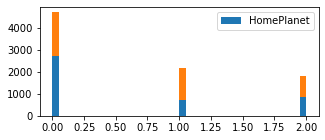

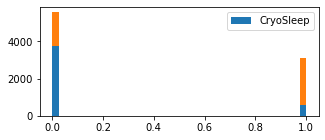

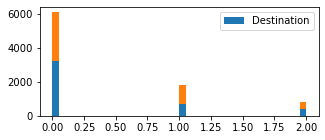

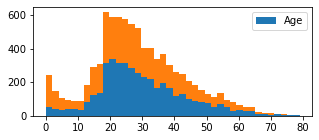

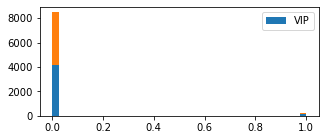

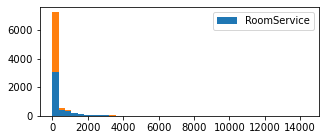

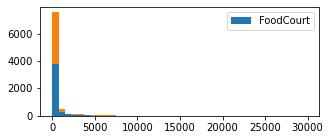

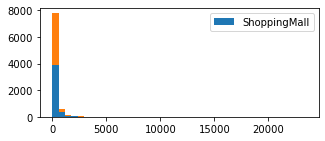

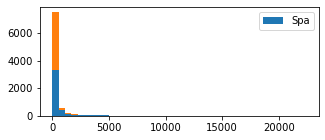

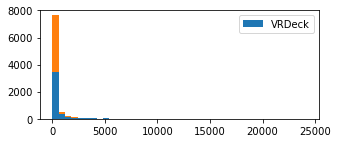

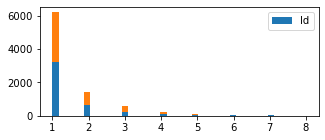

No handles with labels found to put in legend.


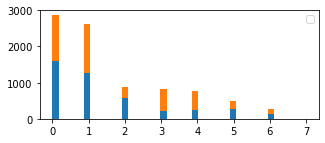

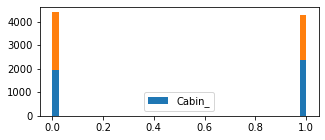

No handles with labels found to put in legend.


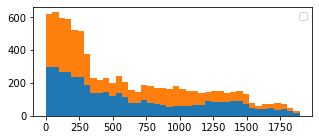

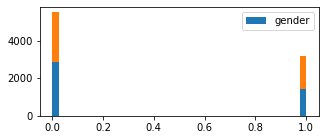

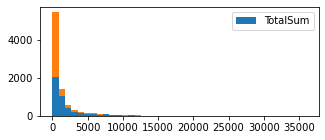

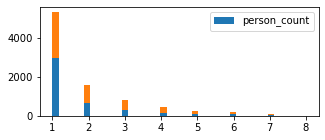

In [66]:
cols = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", "FoodCourt",
        "ShoppingMall", "Spa", "VRDeck", "Id", "_Cabin", "Cabin_", "_Cabin_", "gender",
        "TotalSum", "person_count"] 

for col in cols:
    plt.figure(figsize=(5, 2))
    plt.hist([df_pickle[df_pickle[target] == 0][col], df_pickle[df_pickle[target] == 1][col]], 
              stacked=True, 
              bins=40, 
              label=col)
    plt.legend()
    plt.show()

In [67]:
df_pickle.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Id,_Cabin,Cabin_,_Cabin_,gender,TotalSum,person_count
9681,0.0,0.0,1.0,21.0,0.0,0.0,722.0,0.0,0.0,0.0,-1.0,1.0,0.0,1.0,406.0,1.0,722.0,1
4216,0.0,1.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,736.0,1.0,0.0,1
764,1.0,0.0,1.0,36.0,1.0,0.0,13248.0,100.0,1953.0,1.0,1.0,1.0,4.0,1.0,29.0,1.0,15302.0,1
4632,2.0,0.0,0.0,16.0,0.0,2083.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,0.0,938.0,0.0,2093.0,4
2526,1.0,1.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,105.0,0.0,0.0,1


In [68]:
df_pickle.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age              350
VIP                2
RoomService     1740
FoodCourt       2130
ShoppingMall    1533
Spa             1846
VRDeck          1794
Transported        3
Id                 8
_Cabin             8
Cabin_             2
_Cabin_         2193
gender             2
TotalSum        3477
person_count       8
dtype: int64

In [70]:
homeplanet = pd.get_dummies(df_pickle["HomePlanet"], prefix="hp", drop_first=True)
destination = pd.get_dummies(df_pickle["Destination"], prefix="dst", drop_first=True)
id_ = pd.get_dummies(df_pickle["Id"], prefix="id", drop_first=True)
_cabin = pd.get_dummies(df_pickle["_Cabin"], prefix="_c", drop_first=True)
person = pd.get_dummies(df_pickle["person_count"], prefix="pc", drop_first=True)

In [71]:
df = pd.concat([homeplanet, destination, id_, _cabin, person,
                df_pickle[["CryoSleep",
                           "Age",
                           "VIP",
                           "RoomService",
                           "FoodCourt",
                           "ShoppingMall",
                           "Spa",
                           "VRDeck",
                           "Cabin_",
                           "_Cabin_",
                           "gender",
                           "TotalSum",
                           target]]],
                axis=1)
df.sample(5)

,hp_1.0,hp_2.0,dst_1.0,dst_2.0,id_2.0,id_3.0,id_4.0,id_5.0,id_6.0,id_7.0,...,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_,_Cabin_,gender,TotalSum,Transported
3725,0,0,0,0,1,0,0,0,0,0,...,20.0,0.0,424.0,0.0,359.0,0.0,757.0,0.0,803.0,0.0
4497,1,0,1,0,0,1,0,0,0,0,...,0.0,225.0,0.0,3873.0,240.0,0.0,189.0,1.0,4338.0,0.0
8065,0,1,0,0,0,0,0,0,0,0,...,1234.0,35.0,7.0,0.0,0.0,0.0,1659.0,0.0,1276.0,0.0
8856,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,-1.0
11686,0,0,0,0,0,0,0,0,0,0,...,701.0,23.0,0.0,0.0,0.0,1.0,1367.0,1.0,724.0,-1.0


In [74]:
df.shape

(12970, 38)

In [75]:
df.isna().sum()

hp_1.0          0
hp_2.0          0
dst_1.0         0
dst_2.0         0
id_2.0          0
id_3.0          0
id_4.0          0
id_5.0          0
id_6.0          0
id_7.0          0
id_8.0          0
_c_1.0          0
_c_2.0          0
_c_3.0          0
_c_4.0          0
_c_5.0          0
_c_6.0          0
_c_7.0          0
pc_2            0
pc_3            0
pc_4            0
pc_5            0
pc_6            0
pc_7            0
pc_8            0
CryoSleep       0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Cabin_          0
_Cabin_         0
gender          0
TotalSum        0
Transported     0
dtype: int64

In [93]:
mask = (df.nunique() > 2).values
cont_index = pd.Index([i for i in range(len(df.columns))])[mask]
cat_index  = pd.Index([i for i in range(len(df.columns))])[~mask]

cont_index, cat_index

(Int64Index([26, 28, 29, 30, 31, 32, 34, 36, 37], dtype='int64'),
 Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
             17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 33, 35],
            dtype='int64'))

In [108]:
cont = list(df.columns[cont_index])
cat  = list(df.columns[cat_index])

if target not in cont:
    cont += [target]

if target not in cat:
    cat += [target]

In [196]:
train_set = df[df[target] != -1].copy()
test_set  = df[df[target] == -1].copy()
# train_set = train_set[cat]

X = train_set.drop(target, axis=1)
test_set = test_set.drop(target, axis=1)
y = train_set[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, stratify=y)

In [170]:
estimators = [LogisticRegression(max_iter=1000),
              RidgeClassifier(),
              KNeighborsClassifier(n_neighbors=10),
              AdaBoostClassifier(),
              ExtraTreesClassifier(),
              GradientBoostingClassifier(),
              LGBMClassifier(),
              RandomForestClassifier(max_depth=9),
              BernoulliNB(),
              GaussianNB()]

for clf in estimators:
    clf.fit(X_train, y_train)
    print(f"Model: {clf}, score: {round(np.mean(clf.predict(X_val) == y_val), 3)}")

Model: LogisticRegression(max_iter=1000), score: 0.793
Model: RidgeClassifier(), score: 0.757
Model: KNeighborsClassifier(n_neighbors=10), score: 0.786
Model: AdaBoostClassifier(), score: 0.801
Model: ExtraTreesClassifier(), score: 0.807
Model: GradientBoostingClassifier(), score: 0.814
Model: LGBMClassifier(), score: 0.81
Model: RandomForestClassifier(max_depth=9), score: 0.803
Model: BernoulliNB(), score: 0.728
Model: GaussianNB(), score: 0.759


In [217]:
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [302]:
train_set = df[df[target] != -1].copy()

X = train_set.drop(target, axis=1)
y = train_set[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size=0.5, stratify=y_val)

In [303]:
# clf = SVC()
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [304]:
print(f"Model: {clf}, score: {round(np.mean(clf.predict(X_val) == y_val), 3)}")

Model: GradientBoostingClassifier(), score: 0.82


In [305]:
# proba = clf.decision_function(X_test)
proba = clf.predict_proba(X_test)[:, 1]
predicted = clf.predict(X_test)

In [306]:
true, pred = calibration_curve(y_test, proba, normalize=True, n_bins=20)

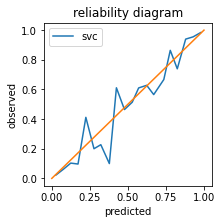

In [307]:
plt.figure(figsize=(3, 3))
plt.plot(pred, true, label="svc")
plt.legend()
plt.xlabel("predicted")
plt.ylabel("observed")
plt.title("reliability diagram")
plt.plot([0, 1], [0, 1])
plt.show()

In [308]:
calibrator = CalibratedClassifierCV(clf, cv="prefit", method="sigmoid")
calibrator.fit(X_val, y_val)

CalibratedClassifierCV(base_estimator=GradientBoostingClassifier(), cv='prefit')

In [309]:
predict = calibrator.predict(X_test)

In [310]:
true, pred = calibration_curve(y_test, predict, n_bins=20)

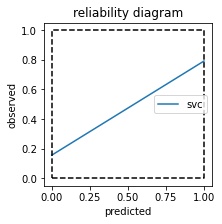

In [335]:
plt.figure(figsize=(3, 3))
plt.plot(pred, true, label="svc")
plt.legend()
plt.xlabel("predicted")
plt.ylabel("observed")
plt.title("reliability diagram")
plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], "k", linestyle='dashed')
plt.show()

In [312]:
np.mean(predict == y_test)

0.8149425287356322

In [313]:
predict = clf.predict(X_test)
np.mean(predict == y_test)

0.8160919540229885

In [314]:
np.mean(predicted == y_test)

0.8160919540229885

In [186]:
estimators = [("lg", LogisticRegression(max_iter=1000)),
              ("rg", RidgeClassifier()),
              ("kn", KNeighborsClassifier(n_neighbors=10)),
              ("ab", AdaBoostClassifier()),
              ("et", ExtraTreesClassifier()),
              ("gb", GradientBoostingClassifier()),
              ("lm", LGBMClassifier()),
              ("rf", RandomForestClassifier(max_depth=9)),
              ("br", BernoulliNB()),
              ("ga", GaussianNB()),
              ("sv", SVC())]

clf = VotingClassifier(estimators)
clf.fit(X_train, y_train)
predicted = clf.predict(X_val)

print(f"Voting score: {round(np.mean(predicted == y_val), 3)}")

Voting score: 0.815


In [195]:
y_train.value_counts() / len(y_train)

1.0    0.503643
0.0    0.496357
Name: Transported, dtype: float64

In [194]:
np.bincount(predicted.astype(int)) / len(predicted)

array([0.45862069, 0.54137931])

In [137]:
train_set.columns

Index(['hp_1.0', 'hp_2.0', 'dst_1.0', 'dst_2.0', 'id_2.0', 'id_3.0', 'id_4.0',
       'id_5.0', 'id_6.0', 'id_7.0', 'id_8.0', '_c_1.0', '_c_2.0', '_c_3.0',
       '_c_4.0', '_c_5.0', '_c_6.0', '_c_7.0', 'pc_2', 'pc_3', 'pc_4', 'pc_5',
       'pc_6', 'pc_7', 'pc_8', 'CryoSleep', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_', '_Cabin_',
       'gender', 'TotalSum', 'Transported'],
      dtype='object')

In [138]:
parameters = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSum', target]

In [139]:
# train_set[parameters[:-1]] = train_set[parameters[:-1]].apply(lambda x: np.log(x + 1))
train_set[parameters].head(5)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSum,Transported
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0,736.0,1.0
2,43.0,3576.0,0.0,6715.0,49.0,10383.0,0.0
3,0.0,1283.0,371.0,3329.0,193.0,5176.0,0.0
4,303.0,70.0,151.0,565.0,2.0,1091.0,1.0


In [140]:
parameters = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', '_Cabin_', 'TotalSum']

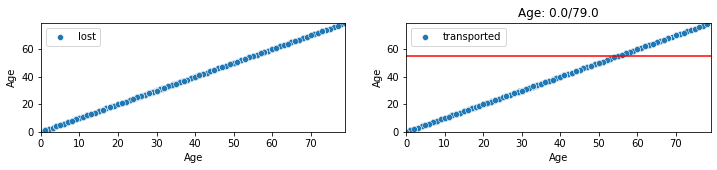

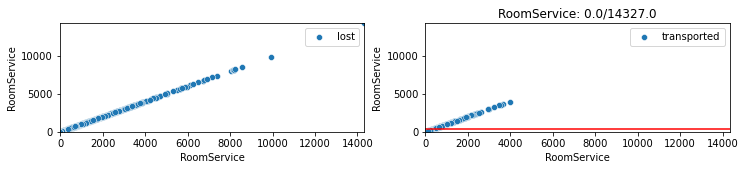

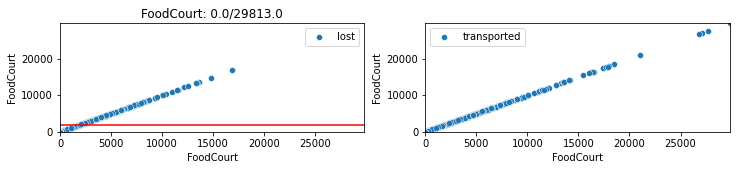

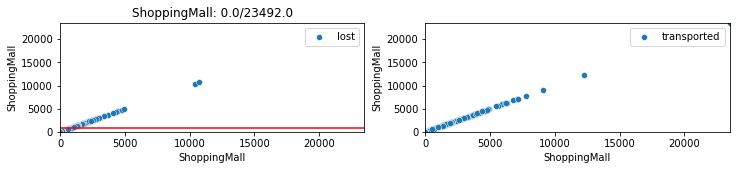

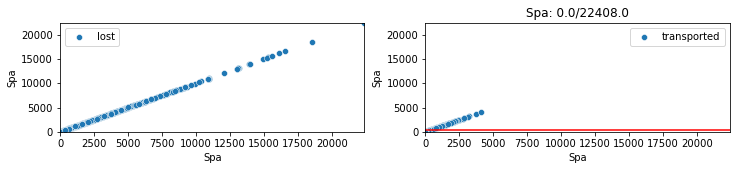

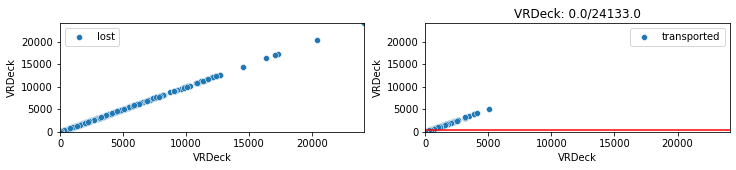

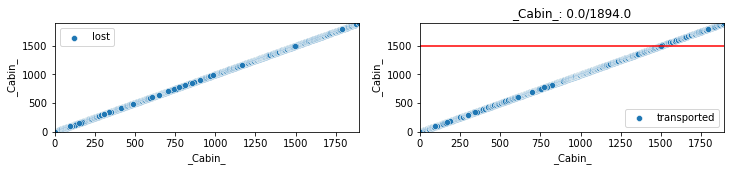

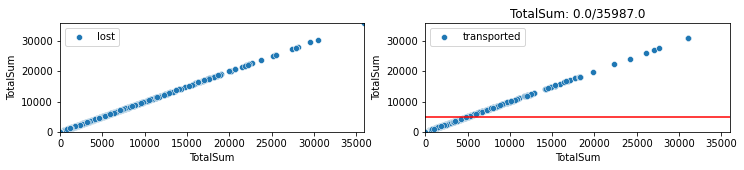

In [146]:
hardcode = set()
echo = True
margine = 5 #%

for parameter in parameters:          
    lost = train_set[train_set[target] == 0].copy()
    transported = train_set[train_set[target] == 1].copy()

    pmax = max(lost[parameter].max(), transported[parameter].max())
    pmin = min(lost[parameter].min(), transported[parameter].min())

    if lost[parameter].max() < transported[parameter].max():
        grapth = 0
        pedge = np.sort(lost[parameter])[int(len(lost[parameter]) * (1 - margine/100) - 1)]
    else:
        grapth = 1
        pedge = np.sort(transported[parameter])[int(len(transported[parameter]) * (1 - margine/100) - 1)]            

    hardcode.add((parameter, ">", pedge, abs(grapth - 1)))

    if not echo:
        continue

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 2))

    sns.scatterplot(data=lost, x=parameter, y=parameter, ax=axes[0], label="lost")
    sns.scatterplot(data=transported, x=parameter, y=parameter, ax=axes[1], label="transported")

    if lost[parameter].max() != transported[parameter].max():
        axes[grapth].plot([pmax, pmin], [pedge, pedge], c="red")

    axes[0].set_ylim(pmin, pmax)
    axes[1].set_ylim(pmin, pmax)

    axes[0].set_xlim(pmin, pmax)
    axes[1].set_xlim(pmin, pmax)

    axes[grapth].set_title(parameter + ": " +str(pmin) + "/" + str(pmax))

    plt.legend()
    plt.show()

In [147]:
hardcode

{('Age', '>', 55.0, 0),
 ('FoodCourt', '>', 1961.0, 1),
 ('RoomService', '>', 382.0, 0),
 ('ShoppingMall', '>', 880.0, 1),
 ('Spa', '>', 394.0, 0),
 ('TotalSum', '>', 4888.0, 0),
 ('VRDeck', '>', 487.0, 0),
 ('_Cabin_', '>', 1502.0, 0)}

In [148]:
X = train_set.drop(target, axis=1)
y = train_set[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9)

In [149]:
estimators = [LogisticRegression(max_iter=1000),
              RidgeClassifier(),
              KNeighborsClassifier(n_neighbors=10),
              AdaBoostClassifier(),
              ExtraTreesClassifier(),
              GradientBoostingClassifier(),
              LGBMClassifier(),
              RandomForestClassifier(max_depth=9),
              BernoulliNB(),
              GaussianNB()]


for clf in estimators:
    clf.fit(X_train, y_train)

    predict = clf.predict(X_val)
    initial_score = np.mean(predict == y_val)
    print("Score: ", round(initial_score, 3), "\t", str(clf)[:str(clf).find("(")])
    
    y_corrected = y_val.copy()
    count = 0
    
    for parameter, sign, value, aim in hardcode:
        index = X_val[X_val[parameter] > value].index
        y_corrected[index] = aim
        count += len(index)
    
    print("_____: ", round(np.mean(predict == y_corrected), 3))

Score:  0.795 	 LogisticRegression
_____:  0.787
Score:  0.79 	 RidgeClassifier
_____:  0.784
Score:  0.776 	 KNeighborsClassifier
_____:  0.768
Score:  0.775 	 AdaBoostClassifier
_____:  0.757
Score:  0.8 	 ExtraTreesClassifier
_____:  0.785
Score:  0.797 	 GradientBoostingClassifier
_____:  0.777
Score:  0.803 	 LGBMClassifier
_____:  0.789
Score:  0.792 	 RandomForestClassifier
_____:  0.784
Score:  0.761 	 BernoulliNB
_____:  0.739
Score:  0.746 	 GaussianNB
_____:  0.722


In [150]:
count

643

In [177]:
estimators = [("lg", LogisticRegression(max_iter=1000)),
              ("rg", RidgeClassifier()),
              ("kn", KNeighborsClassifier(n_neighbors=10)),
              ("ab", AdaBoostClassifier()),
              ("et", ExtraTreesClassifier()),
              ("gb", GradientBoostingClassifier()),
              ("lm", LGBMClassifier()),
              ("rf", RandomForestClassifier(max_depth=9)),
              ("br", BernoulliNB()),
              ("ga", GaussianNB()),
              ("sv", SVC())]

clf = VotingClassifier(estimators)
clf.fit(X, y)

print(f"Voting score: {round(np.mean(clf.predict(X) == y), 3)}")

c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting score: 0.837


In [178]:
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [179]:
predict = clf.predict(test_set)

In [180]:
submission[target] = predict.astype("bool")
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [181]:
name = "submission.csv"
submission.to_csv(name, index=False)

zout = zipfile.ZipFile(name +".zip", "w", zipfile.ZIP_DEFLATED)
zout.write(name)
zout.close()

In [182]:
!kaggle competitions submit -f submission.csv.zip -m vot_nan_model_gender_svm -c spaceship-titanic


  0%|          | 0.00/11.1k [00:00<?, ?B/s]
 72%|#######2  | 8.00k/11.1k [00:00<00:00, 20.2kB/s]
100%|##########| 11.1k/11.1k [00:02<00:00, 5.11kB/s]


In [183]:
!kaggle competitions submissions -c spaceship-titanic

fileName            date                 description               status    publicScore  privateScore  
------------------  -------------------  ------------------------  --------  -----------  ------------  
submission.csv.zip  2022-09-28 07:15:57  vot_nan_model_gender_svm  complete  0.80173                    
submission.csv.zip  2022-09-28 07:03:48  vot_nan_model_gender      complete  0.80266                    
submission.csv.zip  2022-09-20 08:38:50  lgbm_onehot2              complete  0.79611                    
submission.csv.zip  2022-09-20 08:37:43  lgbm_onehot               complete  0.79611                    
submission.csv.zip  2022-09-19 12:49:42  gbm_onehot                complete  0.79962                    


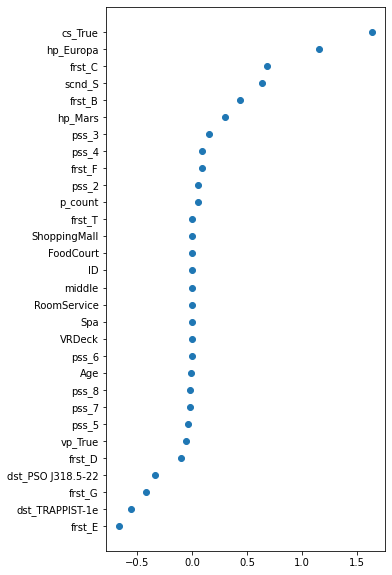

In [82]:
plt.figure(figsize=(5, 10))
index = np.argsort(clf.coef_[0])
plt.plot(clf.coef_[0][index], df.columns[:-1][index], "o")
plt.show()

In [262]:
depth = []
score = []

for dep in tqdm(range(3, 30, 1)):
    clf = RandomForestClassifier(max_depth=dep)
#     clf = KNeighborsClassifier(n_neighbors=dep)
    
    clf.fit(X_train, y_train)
    depth.append(dep)

    score.append(np.sum(clf.predict(X_val) == y_val) / len(y_val))

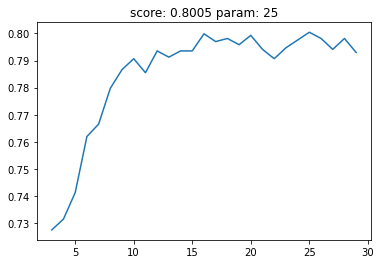

In [263]:
plt.plot(depth, score)
plt.title("score: " + str(round(max(score), 4)) + " param: " + str(depth[np.argmax(score)]))
plt.show()

In [342]:
class RSwA:
    def __init__(self, X, y, iterations=100, 
                 manipulations=None, model=None, desired_score=None,
                 test_size=0.8, cv=5):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.iterations = iterations
        self.manipulations = manipulations
        self.desired_score = desired_score
        self.model = model
        
        self.genes     = np.ones((len(manipulations), X.shape[1]))
        self.weights   = np.ones((len(manipulations), X.shape[1]))
        self.d_weights = pd.DataFrame(columns=[str(i) for i in range(len(manipulations) * X.shape[1])])
        
        self.cv_best_score = [] # лучшее качество в поколении
        self.best_genes = None  # лучший набор ген
        self.at_iteration = 0   # ...на итерации
        self.cv_all_scores = []
        self.score = 0
        self.count = 0  
        self.cv = cv
    
    def set_genes(self):
        b = np.array([int(i) for i in self.manipulations]).reshape(len(self.manipulations), 1)  
        self.weights = self.weights * b
        a = self.weights.ravel().copy()
        shoots = int(b.sum() * self.weights.shape[1] * 0.5)

        for i in range(1, len(a), 1):
            a[i] = a[i] + a[i-1]

        for i in range(0, len(a), 1):
            a[i] = a[i] / a.max()

        indexes = set()
            
#         while len(indexes) < shoots:
        for i in range(shoots):    
            shoot = np.random.random()

            k = 0
            while  k < len(a) and a[k] < shoot:
                k += 1

            indexes.add(k)
        
        shape = self.weights.shape
        genes = [0] * shape[0] * shape[1]

        for i in range(len(genes)):
            if i in indexes:
                genes[i] = 1

        self.genes = np.reshape(genes, shape)
#         plot_importance2(rs.genes, text="what to use")

    def add_feature(self):
        # формирование признаков по заданным в хромосоме манипуляциям
        X_new = []
        for i in range(self.X.shape[1]): 
            if self.genes[0, i]: X_new.append(self.X[:, i])
            if self.genes[1, i]: X_new.append(self.X[:, i]**2)
            if self.genes[2, i] and 0 not in self.X[:, i]: X_new.append(1 / self.X[:, i])
    #         if self.genes[3, i]: X_new.append(np.exp(self.X[:, i]))
            if self.genes[3, i]: X_new.append(np.sin(self.X[:, i]))

        X_new = np.array(X_new).T
        return X_new

    def fitness_func(self):  
        # расчет качества модели по скользящему контролю
        X_new = self.add_feature()
        
        if self.cv is None:
            X_train, X_test, y_train, y_test = train_test_split(X_new, self.y,
                                                                test_size=self.test_size,
                                                                stratify=self.y)
            model.fit(X_train, y_train)
            predict = model.predict(X_test)
            cv_score = accuracy_score(y_test, predict)
        
        if self.cv:
            cv_score = cross_val_score(model, X_new, self.y, scoring="accuracy", cv=self.cv).mean()
        
        self.count += 1
        self.cv_all_scores.append(cv_score)

        if cv_score > self.score:
            self.score = cv_score
            self.best_genes = self.genes
            self.at_iteration = self.count

        return (cv_score)

    def change_weights(self, adapt):
#         plot_importance2(rs.weights, text="weights")
        a = self.weights.ravel().copy()
        g = self.genes.ravel().copy()

        for i in range(len(a)):
            if g[i]:
                a[i] = a[i] * adapt
        
        self.weights = np.reshape(a, self.weights.shape)
        
        temporary = pd.DataFrame([a], columns=self.d_weights.columns)
        self.d_weights = self.d_weights.append(temporary, ignore_index=True)
#         plot_importance2(rs.weights, text="weights")
        
    def go_search(self):
        
        for index, i in enumerate(self.manipulations):
            if i and self.weights[index, :].sum() == 0.0:
                self.weights[index, :] = 1
        
        self.set_genes()
        self.add_feature()
        self.fitness_func()
        
        if len(self.cv_all_scores) == 1:
            return   
        
#         print("было: ", self.cv_all_scores[-2], "стало: ", self.cv_all_scores[-1])
        
        if self.cv_all_scores[-1] > self.cv_all_scores[-2] * 1.01:
            self.change_weights(1.1)    
        elif self.cv_all_scores[-1] < self.cv_all_scores[-2] * 0.99:
            self.change_weights(0.9) 

In [343]:
def plot_results(vmin=0, vmax=1, initial_score=0):
    if echo:
        print("Best chromosome:\n", rs.best_genes,
          "\n\nwith score: ", rs.score, " at iteration # ", rs.at_iteration)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3)) 

    axes[0].plot(np.log(rs.d_weights), label="weights",)
    axes[0].set_ylabel('log(weights)')
    axes[0].set_xlabel('iterations')    
    
    axes[1].plot(rs.cv_all_scores, label="selected features")
    axes[1].set_ylabel("log loss")
#     axes[1].plot([0, len(rs.cv_all_scores) - 1], [1, 1], c="k")
    axes[1].plot([0, len(rs.cv_all_scores) - 1], [initial_score, initial_score], c="r", label="all features")
    axes[1].set_xlabel('iterations')
    axes[1].set_ylim(vmin, vmax)
#     axes[0].set_ylim(vmin, vmax)
    plt.legend(loc='lower right')
    plt.show()

In [344]:
def plot_importance(cmap, features):
    plt.figure(figsize=(15, 2))
    plt.pcolormesh(rs.weights, cmap=cmap)
    
#     plt.xticks(np.arange(rs.weights.shape[1]) + 0.5, ["x" + str(i) for i in range(rs.weights.shape[1])])
    
    plt.xticks(np.arange(rs.weights.shape[1]) + 0.5, features, rotation=90)
    plt.yticks(np.arange(rs.weights.shape[0]) + 0.5, manipulations)
    
    plt.xlabel("features")
    plt.ylabel("manipulations")
    plt.title("Features weights")
    
    for i in range(rs.weights.shape[1]):
        for j in range(rs.weights.shape[0]):
            plt.text(i + 0.5, j + 0.5, round(rs.weights[j , i], 2), 
                     ha='center', va='center', color="orange")

    plt.show()

In [345]:
manipulations = ["x", "x2", "1/x", "sin(x)"] # допустимые манипуляции над признаками

In [352]:
# model = LogisticRegression(max_iter=500)
# model = RandomForestClassifier(max_depth=9)
# model = GradientBoostingClassifier()
model = LGBMClassifier()
# model = GaussianNB()
# model = BernoulliNB()

rs = RSwA(np.array(X),
          np.array(y),          # передаем признаки и целевую переменную
          iterations=1000,       # число итераций
          manipulations="1100", # какие манипуляции над признаками пробовать
          model=model,          # модель
          desired_score=None,   # желаемое качество
          test_size=0.8,        # use this split is cv is set None
          cv=None)              # if is not None score will be defined by cross validation

for i in tqdm(range(rs.iterations)):
    rs.go_search()
    
    if rs.desired_score is not None and rs.desired_score >= rs.score:
        break
    
print("*** DONE ***")


*** DONE ***


Best chromosome:
 [[0 0 1 0 1 1]
 [0 1 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] 

with score:  0.7813084112149533  at iteration #  692


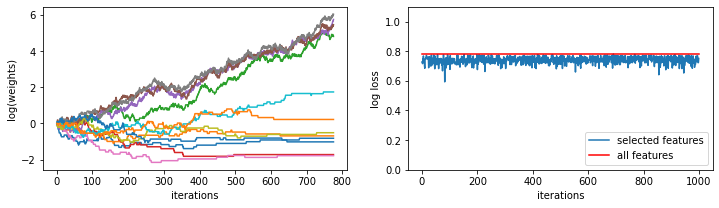

In [353]:
initial_score = 0.782
echo = True

plot_results(vmin=0.0, vmax=1.1, initial_score=initial_score)

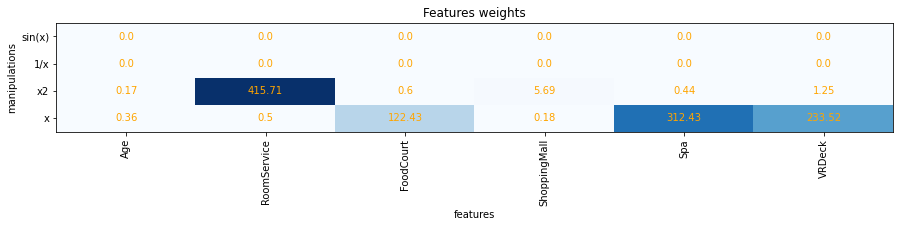

In [354]:
plot_importance(cmap='Blues', features=X.columns)

In [296]:
parameters = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSum', target]

In [297]:
pair = data[data[target] != -1].dropna().copy()

pair[parameters[:-1]] = pair[parameters[:-1]].apply(lambda x: np.log(x + 1))
pair[parameters].head(5)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSum,Transported
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,4.700480,2.302585,3.258097,6.309918,3.806662,6.602588,1
2,3.784190,8.182280,0.000000,8.812248,3.912023,9.248021,0
3,0.000000,7.157735,5.918894,8.110728,5.267858,8.551981,0
4,5.717028,4.262680,5.023881,6.338594,1.098612,6.995766,1


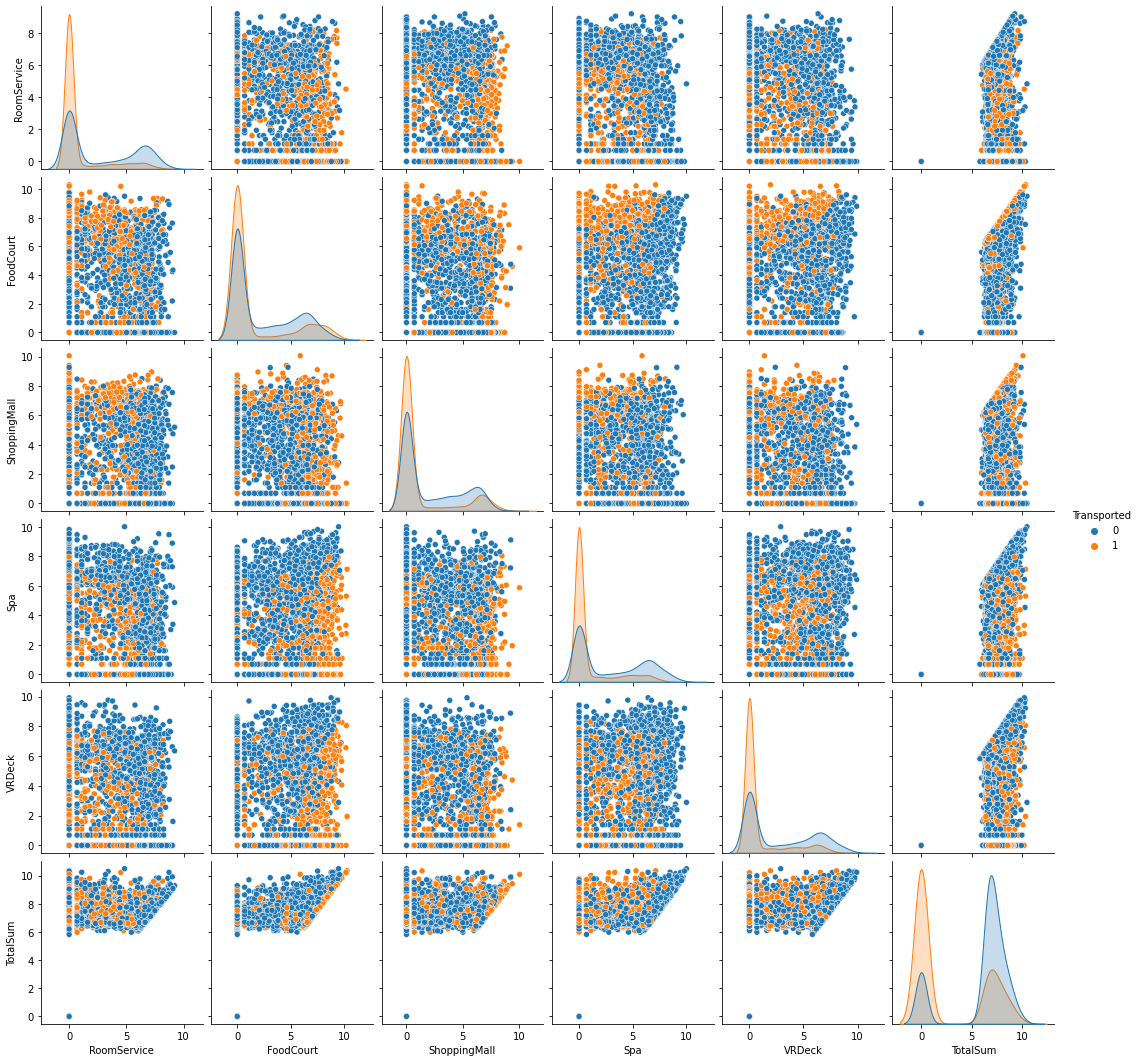

In [298]:
sns.pairplot(pair[parameters], hue=target)

In [142]:
train_set.columns

Index(['pss_2', 'pss_3', 'pss_4', 'pss_5', 'pss_6', 'pss_7', 'pss_8',
       'hp_Europa', 'hp_Mars', 'dst_PSO J318.5-22', 'dst_TRAPPIST-1e',
       'cs_True', 'vp_True', 'cp_B', 'cp_C', 'cp_D', 'cp_E', 'cp_F', 'cp_G',
       'cp_T', 'cf_S', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Id', 'Cabin_number', 'person_count', 'TotalSum',
       'Transported'],
      dtype='object')

In [146]:
parameters = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Cabin_number', 'person_count', 'TotalSum']

In [148]:
train_set[parameters].head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_number,person_count,TotalSum
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,0,1,736.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,2,10383.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,2,5176.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1,1,1091.0


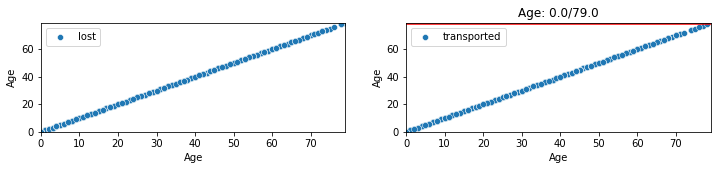

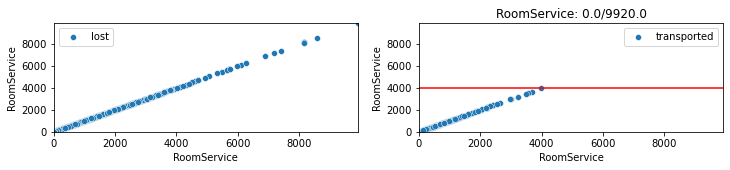

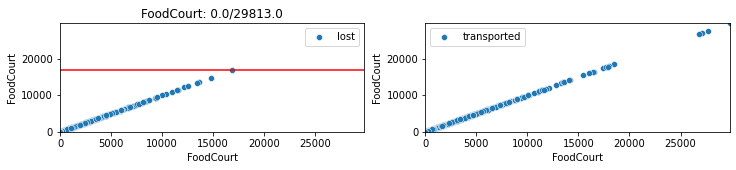

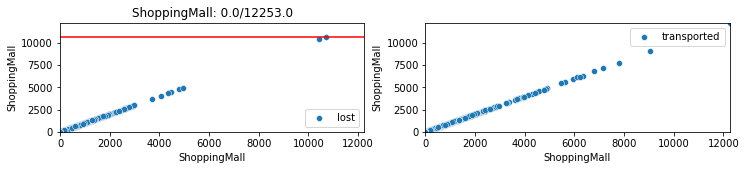

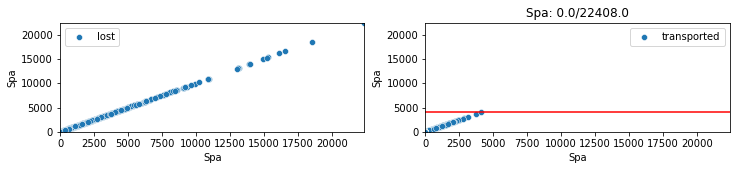

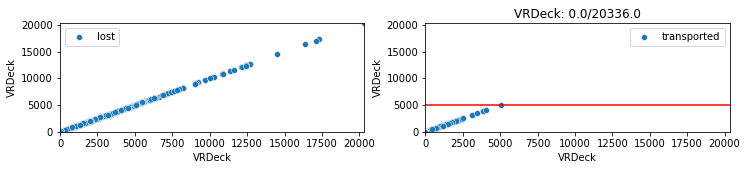

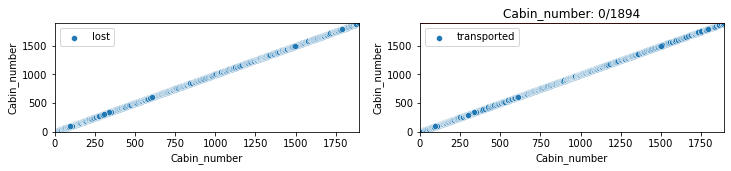

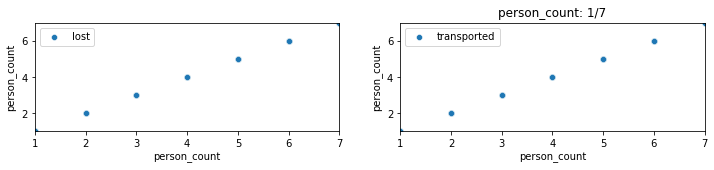

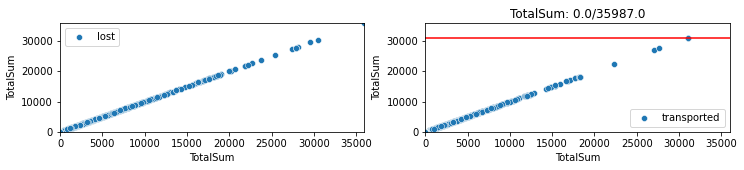

In [253]:
parameters = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Cabin_number', 'person_count', 'TotalSum']


hardcode = set()
echo = True

for par1 in parameters:        
        lost = train_set[train_set[target] == 0].copy()
        transported = train_set[train_set[target] == 1].copy()
        
        pmax = max(lost[par1].max(), transported[par1].max())
        pmin = min(lost[par1].min(), transported[par1].min())
        
        grapth = 0 if lost[par1].max() < transported[par1].max() else 1
        pedge = min(lost[par1].max(), transported[par1].max())
        
        
        hardcode.add((par1, ">", pedge, abs(grapth - 1)))
        
        if not echo:
            continue
            
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 2))

        sns.scatterplot(data=lost, x=par1, y=par1, ax=axes[0], label="lost")
        sns.scatterplot(data=transported, x=par1, y=par1, ax=axes[1], label="transported")

        if lost[par1].max() != transported[par1].max():
            axes[grapth].plot([pmax, pmin], [pedge, pedge], c="red")

        axes[0].set_ylim(pmin, pmax)
        axes[1].set_ylim(pmin, pmax)

        axes[0].set_xlim(pmin, pmax)
        axes[1].set_xlim(pmin, pmax)

        axes[grapth].set_title(par1 + ": " +str(pmin) + "/" + str(pmax))

        plt.legend()
        plt.show()
        
hardcode

for parameter, sign, value, aim in hardcode:
    index = test_set[test_set[parameter] > value].index
    test_set.loc[index, target] = aim

In [254]:
hardcode

{('Age', '>', 78.0, 0),
 ('Cabin_number', '>', 1891, 0),
 ('FoodCourt', '>', 16856.0, 1),
 ('RoomService', '>', 3992.0, 0),
 ('ShoppingMall', '>', 10705.0, 1),
 ('Spa', '>', 4103.0, 0),
 ('TotalSum', '>', 31076.0, 0),
 ('VRDeck', '>', 5063.0, 0),
 ('person_count', '>', 7, 0)}

In [257]:
for parameter, sign, value, aim in hardcode:
    index = test_set[test_set[parameter] > value].index
    test_set.loc[index, target] = aim

In [260]:
test_set.sample(10)

,pss_2,pss_3,pss_4,pss_5,pss_6,pss_7,pss_8,hp_Europa,hp_Mars,dst_PSO J318.5-22,...,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id,Cabin_number,person_count,TotalSum,Transported
9240,0,0,0,0,0,0,0,0,0,1,...,0.0,742.0,0.0,0.0,1.0,7493,1549,1,743.0,NaN
9210,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,7413,1196,2,0.0,NaN
9324,0,0,0,0,0,0,0,1,0,0,...,0.0,394.0,2646.0,99.0,113.0,7706,288,1,3252.0,NaN
7290,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1837,77,1,0.0,NaN
7855,0,0,0,0,0,0,0,0,0,1,...,674.0,0.0,0.0,11.0,0.0,3498,657,1,685.0,NaN
9266,1,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,7558,1568,1,0.0,NaN
9097,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,7135,1166,2,0.0,NaN
6983,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,1023,193,1,0.0,NaN
8620,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,5766,1101,1,0.0,NaN
9713,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,8800,1423,3,0.0,NaN


In [264]:
test_set[test_set[target] == 0]

,pss_2,pss_3,pss_4,pss_5,pss_6,pss_7,pss_8,hp_Europa,hp_Mars,dst_PSO J318.5-22,...,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Id,Cabin_number,person_count,TotalSum,Transported
6684,0,1,0,0,0,0,0,1,0,0,...,0.0,275.0,0.0,4572.0,163.0,194,4,3,5010.0,0.0
6687,1,0,0,0,0,0,0,1,0,0,...,4762.0,20.0,0.0,4.0,41.0,214,12,2,4827.0,0.0
6693,0,0,1,0,0,0,0,1,0,0,...,0.0,1442.0,0.0,1813.0,6439.0,228,4,3,9694.0,0.0
6721,0,0,0,0,0,0,0,1,0,0,...,5.0,11549.0,132.0,4966.0,524.0,300,11,1,17176.0,0.0
6748,0,0,0,0,0,0,0,1,0,0,...,0.0,538.0,0.0,6.0,5288.0,367,11,1,5832.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9766,0,0,0,0,0,0,0,1,0,0,...,0.0,5778.0,0.0,3527.0,6002.0,8934,573,1,15307.0,0.0
9783,1,0,0,0,0,0,0,0,1,0,...,5454.0,34.0,0.0,0.0,0.0,8980,273,6,5488.0,0.0
9796,0,1,0,0,0,0,0,1,0,0,...,0.0,1517.0,0.0,14252.0,4617.0,9016,345,3,20386.0,0.0
9827,0,0,0,0,0,0,0,1,0,0,...,0.0,658.0,0.0,6812.0,0.0,9093,108,1,7470.0,0.0


In [248]:
cols = train.select_dtypes(include=["float", "int"]).columns
cols

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

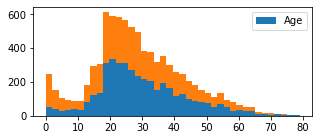

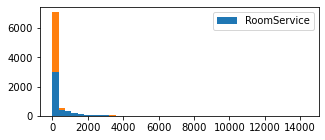

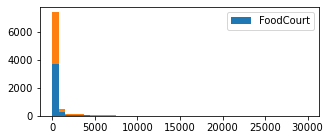

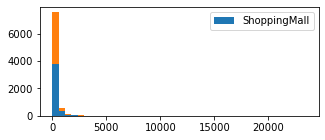

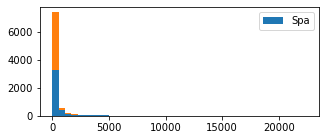

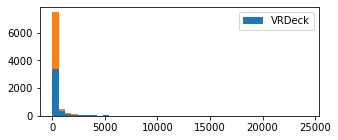

In [249]:
for col in cols:
    plt.figure(figsize=(5, 2))
    plt.hist([train[train[target] == 0][col], train[train[target] == 1][col]], stacked=True, bins=40, label=col)
    plt.legend()
    plt.show()

In [180]:
cols = train.select_dtypes(exclude=["float", "int"]).columns
cols[1: -2]

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'], dtype='object')

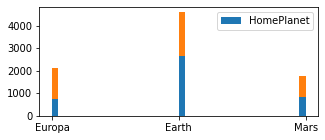

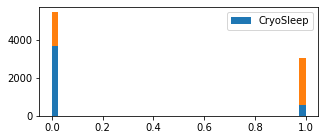

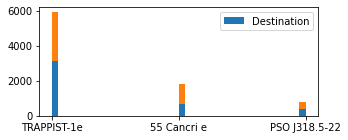

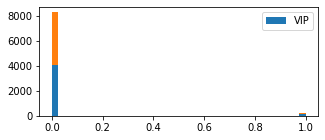

In [197]:
for col in cols[1: -2]:
    if train[train[target] == 0][col].dropna().nunique() > 20:
        continue
    
    plt.figure(figsize=(5, 2))
    plt.hist([train[train[target] == 0][col].dropna(), train[train[target] == 1][col].dropna()],
             stacked=True, bins=40, label=col)
    plt.legend()
    plt.show()

In [202]:
cabin = train[["Cabin", target]].copy()

cabin["Cabin_prefix"] = cabin["Cabin"].str[0]
cabin["Cabin_suffix"] = cabin["Cabin"].str[-1]

cols = ["Cabin_prefix", "Cabin_suffix"]

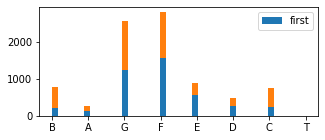

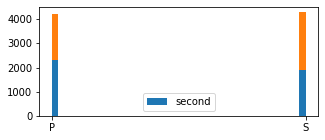

In [203]:
for col in cols:
    plt.figure(figsize=(5, 2))
    plt.hist([cabin[cabin[target] == 0][col].dropna(), cabin[cabin[target] == 1][col].dropna()],
             stacked=True, bins=40, label=col)
    plt.legend()
    plt.show()

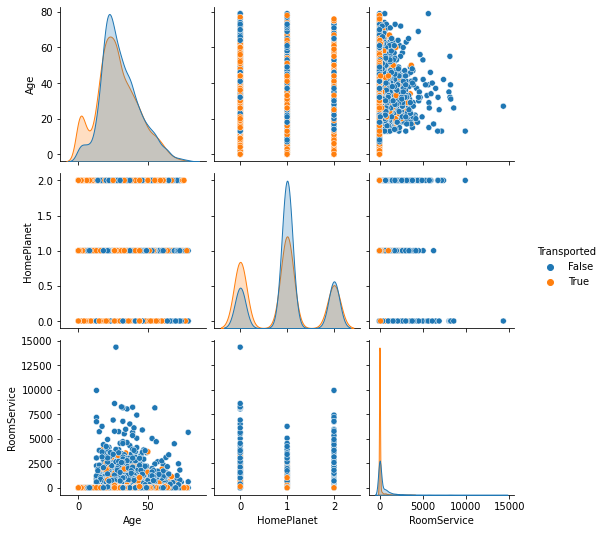

In [237]:
# selected = train[["Age", "HomePlanet", "RoomService", target]].dropna().copy()

sns.pairplot(selected, hue=target)

In [236]:
selected["HomePlanet"].unique()

array([0, 1, 2])

In [234]:
mapping = {"Europa": 0, "Earth": 1, "Mars": 2}

selected["HomePlanet"] = selected["HomePlanet"].map(mapping)
selected["HomePlanet"] = selected["HomePlanet"].astype("int")

In [235]:
selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8141 entries, 0 to 8692
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          8141 non-null   float64
 1   HomePlanet   8141 non-null   int32  
 2   RoomService  8141 non-null   float64
 3   Transported  8141 non-null   bool   
dtypes: bool(1), float64(2), int32(1)
memory usage: 230.6 KB


In [80]:
data[data["CryoSleep"].isna() == True].sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
3839,4108_02,Europa,NaN,B/158/S,TRAPPIST-1e,47.0,False,27.0,2651.0,538.0,18.0,0.0,Tachium Aroodint,1
7936,8474_01,Earth,NaN,F/1632/S,55 Cancri e,21.0,False,39.0,53.0,94.0,33.0,518.0,Eriky Weaves,0
9448,1534_02,Mars,NaN,D/55/S,TRAPPIST-1e,33.0,False,3303.0,0.0,40.0,1.0,0.0,Krunch Rasty,-1
8958,0578_02,Earth,NaN,G/84/S,TRAPPIST-1e,44.0,False,0.0,0.0,0.0,0.0,0.0,Nance Hoppers,-1
5205,5552_01,Mars,NaN,F/1150/P,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,Skix Potie,0


In [77]:
indexes = data[data["HomePlanet"].isna() == True].index

data.loc[indexes, "HomePlanet"] = "NoName"

In [78]:
data["HomePlanet"].value_counts()

Earth     6865
Europa    3133
Mars      2684
NoName     288
Name: HomePlanet, dtype: int64

In [81]:
indexes = data[data["CryoSleep"].isna() == True].index

data.loc[indexes, "CryoSleep"] = -1

In [82]:
data["CryoSleep"].value_counts()

False    8079
True     4581
-1        310
Name: CryoSleep, dtype: int64

In [84]:
indexes = data[data["Destination"].isna() == True].index

data.loc[indexes, "Destination"] = "Nowhere"

In [85]:
data["Destination"].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Nowhere           274
Name: Destination, dtype: int64

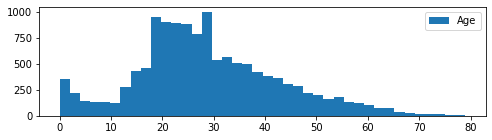

In [98]:
plt.figure(figsize=(8, 2))
plt.hist(data["Age"], bins=40, label="Age")
plt.legend()
plt.show()

In [97]:
indexes = data[data["Age"].isna() == True].index

data.loc[indexes, "Age"] = data["Age"].mean()


In [ ]:
indexes = data[data["VIP"].isna() == True].index

data.loc[indexes, "VIP"] = False

In [99]:
data["VIP"].value_counts()

False    12401
True       273
Name: VIP, dtype: int64

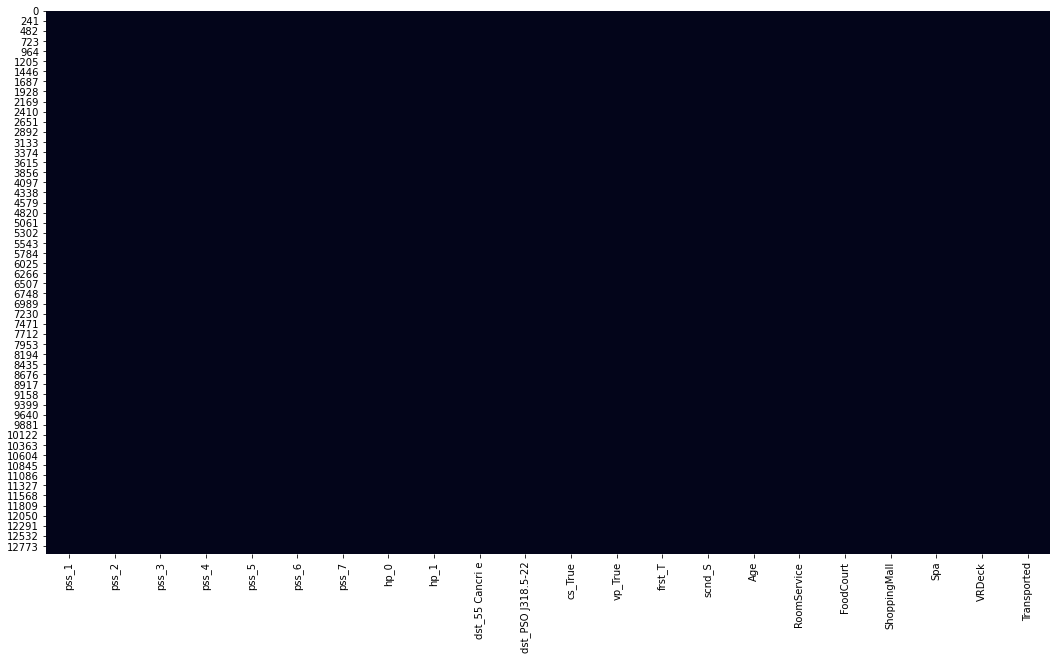

In [36]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.isna(), cbar=False)
plt.show()

In [202]:
data = pd.DataFrame({"par": ["home", "home", "work", "work", "work", "city", "city"],
                     "target": [0, 0, 1, 1, 0, 1, 0]})
data

,par,target
0,home,0
1,home,0
2,work,1
3,work,1
4,work,0
5,city,1
6,city,0


In [203]:
dumm = pd.get_dummies(data["par"])
dumm

,city,home,work
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1
5,1,0,0
6,1,0,0


In [204]:
df1 = pd.concat([dumm, data["target"]], axis=1)
df1

,city,home,work,target
0,0,1,0,0
1,0,1,0,0
2,0,0,1,1
3,0,0,1,1
4,0,0,1,0
5,1,0,0,1
6,1,0,0,0


In [205]:
df2 = pd.DataFrame()

df2["home"] = df1["home"].map(df1.groupby("home")["target"].mean())
df2["work"] = df1["work"].map(df1.groupby("work")["target"].mean())
df2["city"] = df1["city"].map(df1.groupby("city")["target"].mean())
df2["target"] = data["target"]
df2

,home,work,city,target
0,0.0,0.250000,0.4,0
1,0.0,0.250000,0.4,0
2,0.6,0.666667,0.4,1
3,0.6,0.666667,0.4,1
4,0.6,0.666667,0.4,0
5,0.6,0.250000,0.5,1
6,0.6,0.250000,0.5,0


In [206]:
df3 = pd.DataFrame()

df3["par"] = data["par"].map(data.groupby("par")["target"].mean())
df3["target"] = data["target"]
df3

,par,target
0,0.000000,0
1,0.000000,0
2,0.666667,1
3,0.666667,1
4,0.666667,0
5,0.500000,1
6,0.500000,0


In [207]:
X = df1.drop("target", axis=1)
y = df1["target"]

clf = LogisticRegression()
clf.fit(X, y)

clf.predict(X), clf.coef_

(array([0, 0, 1, 1, 1, 0, 0], dtype=int64),
 array([[ 0.1219559 , -0.56499599,  0.44304331]]))

In [208]:
scaler = StandardScaler()

In [209]:
X = df2.drop("target", axis=1)

X = scaler.fit_transform(X)

clf = LogisticRegression()
clf.fit(X, y)

clf.predict(X), clf.coef_

(array([0, 0, 1, 1, 1, 0, 0], dtype=int64),
 array([[0.61428057, 0.42436514, 0.14941185]]))

In [210]:
X = df3.drop("target", axis=1)

X = scaler.fit_transform(X)

clf = LogisticRegression()
clf.fit(X, y)

clf.predict(X), clf.coef_

(array([0, 0, 1, 1, 1, 0, 0], dtype=int64), array([[0.78308442]]))